This notebook compares different 3D CNN architectures for medical image classification:

ResNet-18 (3D) - Recommended default (~33M params)
ResNet-34 (3D) - More capacity (~63M params)
ResNet-50 (3D) - Maximum performance (~46M params)
DenseNet-121 (3D) - Efficient feature reuse (~5.6M params)
EfficientNet-B0 (3D) - Most parameter efficient (~1.2M params)

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from utils.cnn_3d_models import get_3d_model
from utils.data_loader import get_medmnist_dataloaders
from utils.metrics import evaluate_model
from config import *

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Device: {DEVICE}")
set_seed(42)

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


In [2]:
# Load test dataset
_, _, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=32,
    num_workers=4
)

print(f"Test set loaded: {len(test_loader.dataset)} samples")
print(f"Number of classes: {num_classes}")

# Create output directories
Path('../results').mkdir(exist_ok=True)
Path('../figures').mkdir(exist_ok=True)
print("Output directories ready")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Test set loaded: 610 samples
Number of classes: 11
Output directories ready


In [3]:
# Architectures to compare
ARCHITECTURES = {
    'ResNet-18': 'resnet18_3d',
    'ResNet-34': 'resnet34_3d',
    'ResNet-50': 'resnet50_3d',
    'DenseNet-121': 'densenet121_3d',
    'EfficientNet-B0': 'efficientnet3d_b0'
}

print("Architectures to compare:")
for name, arch in ARCHITECTURES.items():
    print(f"  - {name:20s} ({arch})")

Architectures to compare:
  - ResNet-18            (resnet18_3d)
  - ResNet-34            (resnet34_3d)
  - ResNet-50            (resnet50_3d)
  - DenseNet-121         (densenet121_3d)
  - EfficientNet-B0      (efficientnet3d_b0)


In [4]:
models = {}
model_info = {}

for name, arch in ARCHITECTURES.items():
    checkpoint_path = Path(f'../models/{arch}_baseline.pth')
    
    # Create model
    model = get_3d_model(arch, num_classes=num_classes).to(DEVICE)
    params = sum(p.numel() for p in model.parameters())
    
    # Try to load checkpoint
    if checkpoint_path.exists():
        try:
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            models[name] = model
            model_info[name] = {
                'architecture': arch,
                'params': params,
                'trained': True,
                'val_acc': max(checkpoint.get('history', {}).get('val_acc', [0.0]))
            }
            print(f"{name:20s} - Loaded ({params/1e6:.1f}M params)")
        except Exception as e:
            print(f"{name:20s} - Error: {e}")
    else:
        model.eval()
        models[name] = model
        model_info[name] = {
            'architecture': arch,
            'params': params,
            'trained': False,
            'val_acc': 0.0
        }
        print(f"{name:20s} - Not trained ({params/1e6:.1f}M params)")

trained_count = sum(1 for info in model_info.values() if info['trained'])
print(f"\n Loaded {len(models)} models ({trained_count} trained)")

ResNet-18            - Loaded (33.2M params)
ResNet-34            - Loaded (63.5M params)
ResNet-50            - Not trained (46.2M params)
DenseNet-121         - Loaded (5.6M params)
EfficientNet-B0      - Loaded (1.2M params)

 Loaded 5 models (4 trained)


In [5]:
# Create summary table
summary_data = []
for name, info in model_info.items():
    summary_data.append({
        'Model': name,
        'Architecture': info['architecture'],
        'Parameters (M)': info['params'] / 1e6,
        'Trained': '✓' if info['trained'] else '✗',
        'Val Accuracy': f"{info['val_acc']:.4f}" if info['trained'] else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

if trained_count == 0:
    print("\n WARNING: No trained models found!")
    print("   Run notebooks 02 and 03 first to train models.")


MODEL SUMMARY
          Model      Architecture  Parameters (M) Trained Val Accuracy
      ResNet-18       resnet18_3d       33.165643       ✓       0.9938
      ResNet-34       resnet34_3d       63.475275       ✓       0.9938
      ResNet-50       resnet50_3d       46.177611       ✗          N/A
   DenseNet-121    densenet121_3d        5.584523       ✓       1.0000
EfficientNet-B0 efficientnet3d_b0        1.219595       ✓       0.9938


In [6]:
results = {}

for name, model in models.items():
    if not model_info[name]['trained']:
        print(f"Skipping {name} (not trained)")
        continue
    
    print(f"\nEvaluating {name}...")
    metrics, preds, labels = evaluate_model(model, test_loader, DEVICE)
    
    results[name] = {
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
        'confusion_matrix': metrics['confusion_matrix'],
        'per_class': metrics['per_class']
    }
    
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")

if results:
    print(f"\n Evaluated {len(results)} model(s)")
else:
    print("\n No trained models to evaluate")


Evaluating ResNet-18...
  Accuracy:  0.9000
  F1-Score:  0.9002

Evaluating ResNet-34...
  Accuracy:  0.8951
  F1-Score:  0.8952
Skipping ResNet-50 (not trained)

Evaluating DenseNet-121...
  Accuracy:  0.9098
  F1-Score:  0.9088

Evaluating EfficientNet-B0...
  Accuracy:  0.8984
  F1-Score:  0.8990

 Evaluated 4 model(s)


In [7]:
if results:
    # Create comparison table
    comparison_data = []
    for name in results.keys():
        comparison_data.append({
            'Model': name,
            'Architecture': model_info[name]['architecture'],
            'Params (M)': model_info[name]['params'] / 1e6,
            'Accuracy': results[name]['accuracy'],
            'Precision': results[name]['precision'],
            'Recall': results[name]['recall'],
            'F1-Score': results[name]['f1_score']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    print("\n" + "="*100)
    print("PERFORMANCE COMPARISON")
    print("="*100)
    print(comparison_df.to_string(index=False))
    print("="*100)
    
    # Save
    comparison_df.to_csv('../results/architecture_comparison.csv', index=False)
    print("\n Saved to '../results/architecture_comparison.csv'")
else:
    print("No results to compare")


PERFORMANCE COMPARISON
          Model      Architecture  Params (M)  Accuracy  Precision   Recall  F1-Score
   DenseNet-121    densenet121_3d    5.584523  0.909836   0.914229 0.909836  0.908758
      ResNet-18       resnet18_3d   33.165643  0.900000   0.904429 0.900000  0.900165
EfficientNet-B0 efficientnet3d_b0    1.219595  0.898361   0.902168 0.898361  0.898988
      ResNet-34       resnet34_3d   63.475275  0.895082   0.905679 0.895082  0.895248

 Saved to '../results/architecture_comparison.csv'


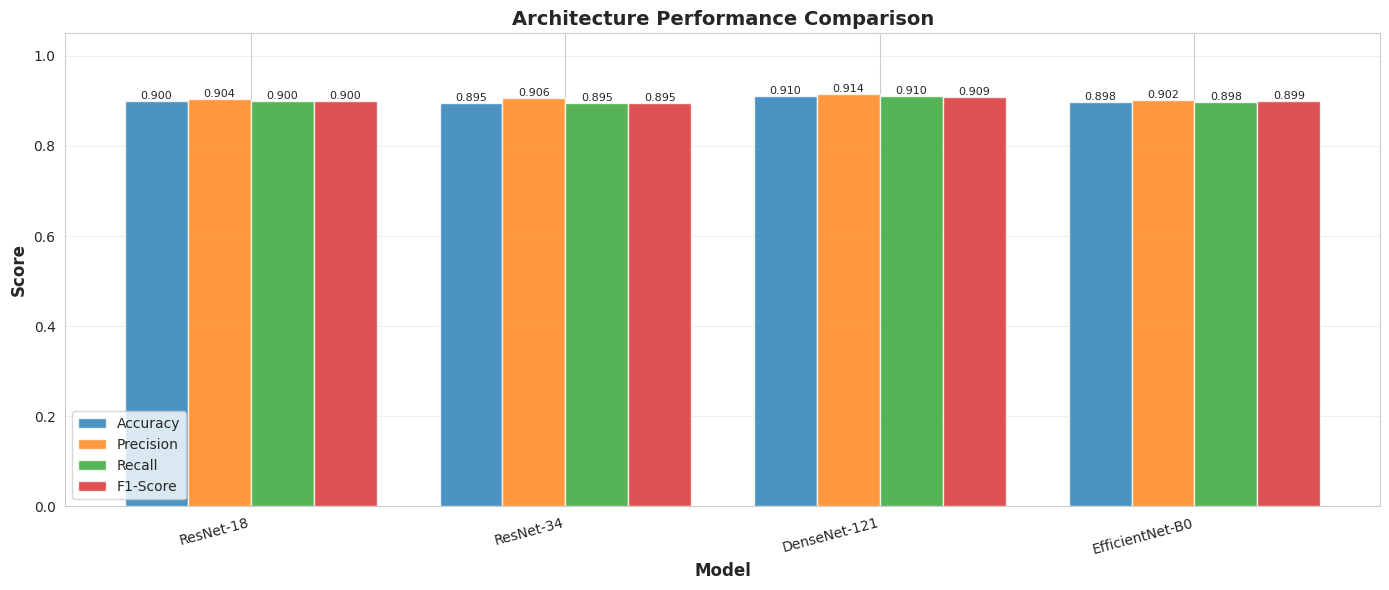

Saved to '../figures/architecture_comparison.png'


In [8]:

if results:
    # Performance bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(results))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        values = [results[name][metric.lower().replace('-', '_')] for name in results.keys()]
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, values, width, label=metric, alpha=0.8)
        
        # Add labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Architecture Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results.keys(), rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('../figures/architecture_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved to '../figures/architecture_comparison.png'")
else:
    print("No results to visualize")

In [9]:
# Stage-wise evaluation of hierarchical classifiers
from utils.hierarchical_model import HierarchicalClassificationModel
from utils.coarse_classifier import CoarseAnatomicalClassifier
from utils.fine_classifier import RegionSpecificPathologyNetwork
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Define architectures to evaluate
STAGE_ARCHITECTURES = {
    'ResNet-18': 'resnet18_3d',
    'ResNet-34': 'resnet34_3d',
    'ResNet-50': 'resnet50_3d',
    'DenseNet-121': 'densenet121_3d',
    'EfficientNet-B0': 'efficientnet3d_b0'
}
# Build organ-to-region mapping
organ_to_region_map = {}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_idx = list(REGION_CONFIGS.keys()).index(region_name)
    organ_to_region_map[organ_idx] = region_idx
REGION_IDX_TO_NAME = {i: name for i, name in enumerate(REGION_CONFIGS.keys())}
# Prepare test data with region labels
all_images = []
all_organ_labels = []
all_region_labels = []
for images, labels in test_loader:
    all_images.append(images)
    all_organ_labels.append(labels.squeeze())
    region_labels = torch.tensor([organ_to_region_map[l.item()] for l in labels.squeeze()])
    all_region_labels.append(region_labels)
test_images = torch.cat(all_images, dim=0).float()
test_organ_labels = torch.cat(all_organ_labels, dim=0)
test_region_labels = torch.cat(all_region_labels, dim=0)
print(f"Test set: {len(test_images)} samples")
print(f"Unique regions: {len(torch.unique(test_region_labels))}")
print(f"Unique organs: {len(torch.unique(test_organ_labels))}")

Test set: 610 samples
Unique regions: 2
Unique organs: 11


In [10]:
# Stage 1 Evaluation: Coarse anatomical region classification
print("\n" + "="*80)
print("STAGE 1: COARSE ANATOMICAL REGION CLASSIFICATION")
print("="*80)

stage1_results = []

for arch_name, arch_type in STAGE_ARCHITECTURES.items():
    print(f"\nEvaluating {arch_name}...")
    
    # Check for trained checkpoint
    checkpoint_path = Path(f'../models/hierarchical_model_{arch_type}.pth')
    
    if not checkpoint_path.exists():
        print(f"  ✗ No trained model found: {checkpoint_path}")
        stage1_results.append({
            'Stage': 'Stage 1',
            'Backbone': arch_name,
            'Accuracy': None,
            'Precision': None,
            'Recall': None,
            'F1-Score': None
        })
        continue
    
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
        print(f"  ✓ Loaded checkpoint from {checkpoint_path}")
        
        # Get saved configs from checkpoint
        saved_region_configs = checkpoint['region_configs']
        num_regions = len(saved_region_configs)
        saved_region_idx_to_name = {i: name for i, name in enumerate(saved_region_configs.keys())}
        
        # Create Stage 1 classifier with correct number of regions
        coarse_model = CoarseAnatomicalClassifier(
            architecture=arch_type,
            num_regions=num_regions,  # Use checkpoint's num_regions
            dropout_rate=0.3,
            region_names=saved_region_idx_to_name
        ).to(DEVICE)
        
        # Load trained weights
        coarse_model.load_state_dict(checkpoint['coarse_model_state'])
        coarse_model.eval()
        
        # Rebuild organ-to-region mapping from checkpoint
        saved_organ_to_region = checkpoint['organ_to_region_map']
        
        # Rebuild test region labels using checkpoint's mapping
        test_region_labels_fixed = torch.tensor([
            saved_organ_to_region[l.item()] for l in test_organ_labels
        ])
        
        # Evaluate in batches
        all_preds = []
        batch_size = 32
        
        with torch.no_grad():
            for i in range(0, len(test_images), batch_size):
                batch = test_images[i:i+batch_size].float().to(DEVICE)
                logits = coarse_model(batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu())
        
        all_preds = torch.cat(all_preds)
        
        # Calculate metrics
        y_true = test_region_labels_fixed.numpy()
        y_pred = all_preds.numpy()
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        stage1_results.append({
            'Stage': 'Stage 1',
            'Backbone': arch_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })
        
        print(f"  Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        
        del coarse_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"  Error: {e}")
        stage1_results.append({
            'Stage': 'Stage 1',
            'Backbone': arch_name,
            'Accuracy': None,
            'Precision': None,
            'Recall': None,
            'F1-Score': None
        })


STAGE 1: COARSE ANATOMICAL REGION CLASSIFICATION

Evaluating ResNet-18...
  ✓ Loaded checkpoint from ../models/hierarchical_model_resnet18_3d.pth
  Accuracy: 0.9721, Precision: 0.9723, Recall: 0.9721, F1: 0.9714

Evaluating ResNet-34...
  ✗ No trained model found: ../models/hierarchical_model_resnet34_3d.pth

Evaluating ResNet-50...
  ✗ No trained model found: ../models/hierarchical_model_resnet50_3d.pth

Evaluating DenseNet-121...
  ✓ Loaded checkpoint from ../models/hierarchical_model_densenet121_3d.pth
  Accuracy: 0.9754, Precision: 0.9752, Recall: 0.9754, F1: 0.9753

Evaluating EfficientNet-B0...
  ✓ Loaded checkpoint from ../models/hierarchical_model_efficientnet3d_b0.pth
  Accuracy: 0.9721, Precision: 0.9720, Recall: 0.9721, F1: 0.9721


In [11]:
# Stage 2 Evaluation: Fine organ classification (using full hierarchical model)
print("\n" + "="*80)
print("STAGE 2: FINE ORGAN CLASSIFICATION (Full Hierarchical Model)")
print("="*80)

stage2_results = []

for arch_name, arch_type in STAGE_ARCHITECTURES.items():
    print(f"\nEvaluating {arch_name}...")
    
    # Check for trained checkpoint
    checkpoint_path = Path(f'../models/hierarchical_model_{arch_type}.pth')
    
    if not checkpoint_path.exists():
        print(f"  ✗ No trained model found: {checkpoint_path}")
        stage2_results.append({
            'Stage': 'Stage 2',
            'Backbone': arch_name,
            'Accuracy': None,
            'Precision': None,
            'Recall': None,
            'F1-Score': None
        })
        continue
    
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
        print(f"Loaded checkpoint from {checkpoint_path}")
        
        # Get saved configs
        saved_region_configs = checkpoint['region_configs']
        saved_organ_to_region = checkpoint['organ_to_region_map']
        
        # Create full hierarchical model
        hierarchical_model = HierarchicalClassificationModel(
            region_configs=saved_region_configs,
            coarse_model_type=arch_type,
            fine_model_type=arch_type,
            dropout_rate=0.3,
            organ_to_region_map=saved_organ_to_region,
            num_total_organs=num_classes,
            region_idx_to_name=REGION_IDX_TO_NAME
        ).to(DEVICE)
        
        # Load trained weights
        hierarchical_model.load_state_dict(checkpoint['hierarchical_model_state'])
        hierarchical_model.eval()
        
        # Evaluate using the standard evaluate_model function
        from utils.metrics import evaluate_model
        metrics, preds, labels = evaluate_model(hierarchical_model, test_loader, DEVICE)
        
        acc = metrics['accuracy']
        prec = metrics['precision']
        rec = metrics['recall']
        f1 = metrics['f1_score']
        
        stage2_results.append({
            'Stage': 'Stage 2',
            'Backbone': arch_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })
        
        print(f"  Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        
        del hierarchical_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"  Error: {e}")
        stage2_results.append({
            'Stage': 'Stage 2',
            'Backbone': arch_name,
            'Accuracy': None,
            'Precision': None,
            'Recall': None,
            'F1-Score': None
        })


STAGE 2: FINE ORGAN CLASSIFICATION (Full Hierarchical Model)

Evaluating ResNet-18...
Loaded checkpoint from ../models/hierarchical_model_resnet18_3d.pth
  Accuracy: 0.7836, Precision: 0.7962, Recall: 0.7836, F1: 0.7843

Evaluating ResNet-34...
  ✗ No trained model found: ../models/hierarchical_model_resnet34_3d.pth

Evaluating ResNet-50...
  ✗ No trained model found: ../models/hierarchical_model_resnet50_3d.pth

Evaluating DenseNet-121...
Loaded checkpoint from ../models/hierarchical_model_densenet121_3d.pth
  Accuracy: 0.8311, Precision: 0.8365, Recall: 0.8311, F1: 0.8299

Evaluating EfficientNet-B0...
Loaded checkpoint from ../models/hierarchical_model_efficientnet3d_b0.pth
  Accuracy: 0.2049, Precision: 0.0716, Recall: 0.2049, F1: 0.0972


In [12]:
# Combine and display stage-wise results
print("\n" + "="*100)
print("STAGE-WISE EVALUATION SUMMARY (Table 2)")
print("="*100)
stagewise_df = pd.DataFrame(stage1_results + stage2_results)
stagewise_df = stagewise_df[['Stage', 'Backbone', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
# Format numeric columns
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    stagewise_df[col] = stagewise_df[col].apply(lambda x: f"{x:.4f}" if x is not None else 'N/A')
print(stagewise_df.to_string(index=False))
print("="*100)
# Save to CSV
stagewise_csv_path = '../results/stagewise_evaluation.csv'
stagewise_df.to_csv(stagewise_csv_path, index=False)
print(f"\n✓ Stage-wise evaluation saved to '{stagewise_csv_path}'")
# Display as formatted table for paper
print("\n" + "-"*100)
print("FORMATTED FOR PAPER (Table 2):")
print("-"*100)
print(f"{'Stage':<12} {'Backbone':<18} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*100)
current_stage = None
for _, row in stagewise_df.iterrows():
    stage_display = row['Stage'] if row['Stage'] != current_stage else ''
    current_stage = row['Stage']
    print(f"{stage_display:<12} {row['Backbone']:<18} {row['Accuracy']:<12} {row['Precision']:<12} {row['Recall']:<12} {row['F1-Score']:<12}")
print("-"*100)


STAGE-WISE EVALUATION SUMMARY (Table 2)
  Stage        Backbone Accuracy Precision Recall F1-Score
Stage 1       ResNet-18   0.9721    0.9723 0.9721   0.9714
Stage 1       ResNet-34      nan       nan    nan      nan
Stage 1       ResNet-50      nan       nan    nan      nan
Stage 1    DenseNet-121   0.9754    0.9752 0.9754   0.9753
Stage 1 EfficientNet-B0   0.9721    0.9720 0.9721   0.9721
Stage 2       ResNet-18   0.7836    0.7962 0.7836   0.7843
Stage 2       ResNet-34      nan       nan    nan      nan
Stage 2       ResNet-50      nan       nan    nan      nan
Stage 2    DenseNet-121   0.8311    0.8365 0.8311   0.8299
Stage 2 EfficientNet-B0   0.2049    0.0716 0.2049   0.0972

✓ Stage-wise evaluation saved to '../results/stagewise_evaluation.csv'

----------------------------------------------------------------------------------------------------
FORMATTED FOR PAPER (Table 2):
----------------------------------------------------------------------------------------------------
Stag

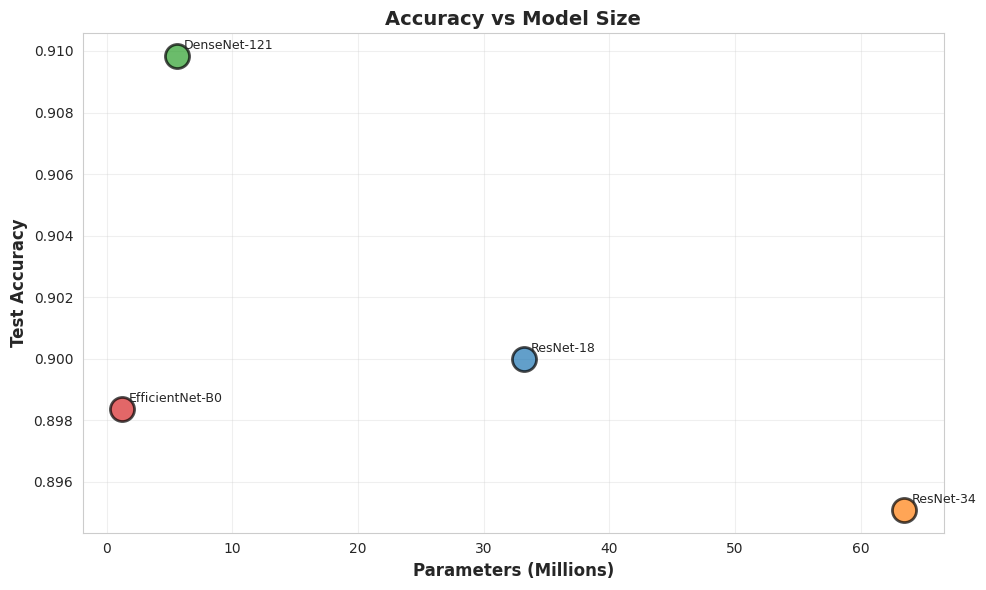

Saved to '../figures/accuracy_vs_parameters.png'


In [13]:
if results:
    # Accuracy vs Parameters
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, name in enumerate(results.keys()):
        params = model_info[name]['params'] / 1e6
        acc = results[name]['accuracy']
        ax.scatter(params, acc, s=300, alpha=0.7, label=name, edgecolors='black', linewidth=2)
        ax.annotate(name, (params, acc), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax.set_xlabel('Parameters (Millions)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/accuracy_vs_parameters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved to '../figures/accuracy_vs_parameters.png'")
else:
    print("No results to visualize")

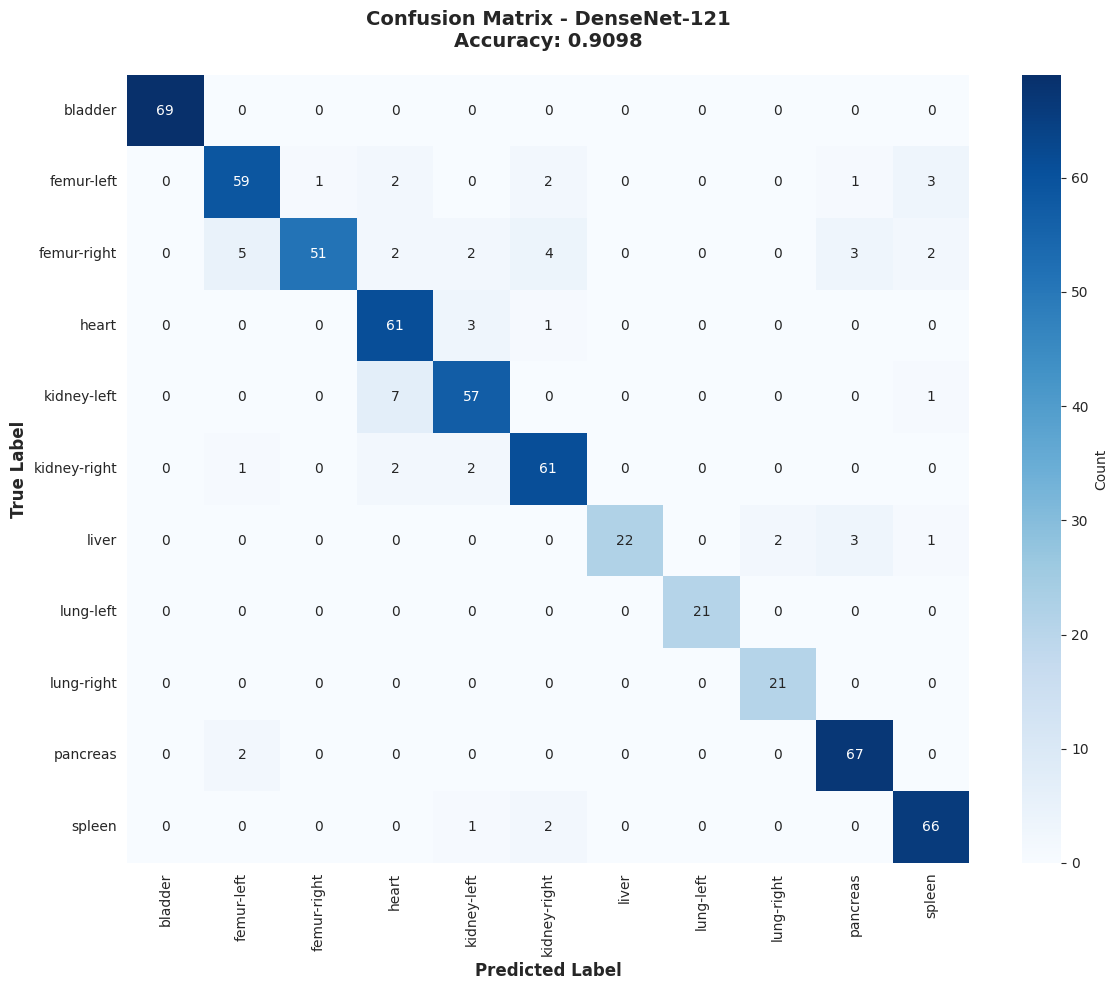

Confusion matrix for DenseNet-121


In [14]:
if results:
    # Best model confusion matrix
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_result = results[best_name]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    class_names = [ORGAN_CLASSES[i] for i in range(num_classes)]
    sns.heatmap(
        best_result['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
        cbar_kws={'label': 'Count'}
    )
    
    ax.set_title(f"Confusion Matrix - {best_name}\nAccuracy: {best_result['accuracy']:.4f}",
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../figures/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Confusion matrix for {best_name}")
else:
    print("No results to visualize")


Per-Class Performance (DenseNet-121):
       Organ  Region  F1-Score  Support
     bladder abdomen  1.000000       69
   lung-left   chest  1.000000       21
  lung-right   chest  0.954545       21
    pancreas abdomen  0.937063       69
      spleen abdomen  0.929577       69
kidney-right abdomen  0.897059       66
       liver abdomen  0.880000       28
       heart   chest  0.877698       65
 kidney-left abdomen  0.876923       65
  femur-left abdomen  0.874074       68
 femur-right abdomen  0.842975       69


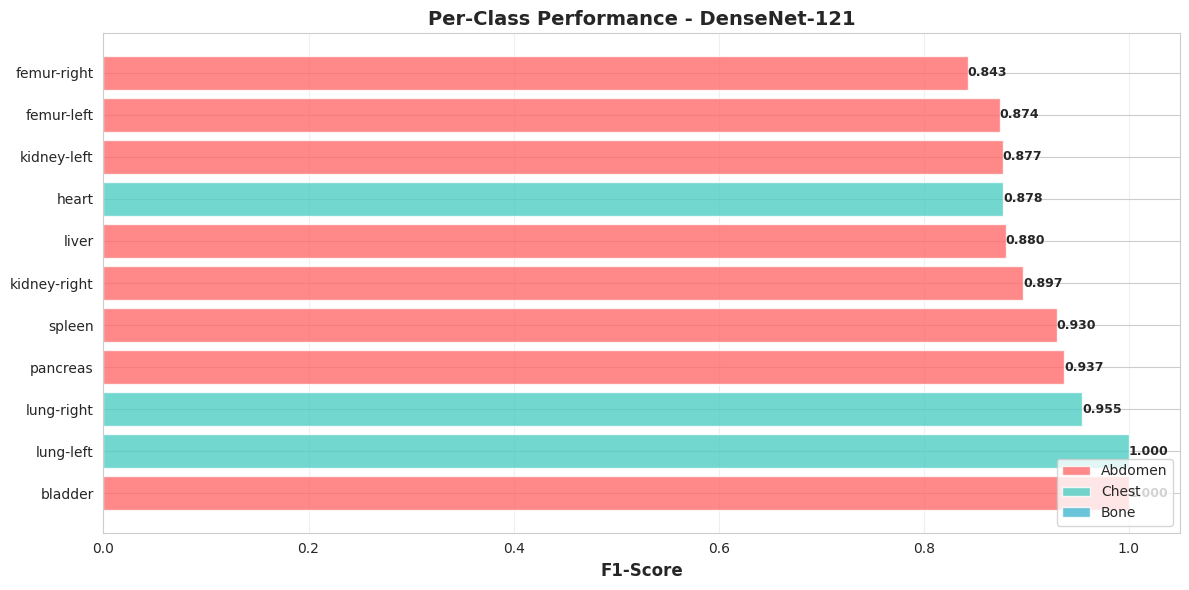

Saved to '../figures/per_class_performance.png'


In [15]:
if results:
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_result = results[best_name]
    
    # Per-class F1 scores
    per_class_df = pd.DataFrame({
        'Organ': [ORGAN_CLASSES[i] for i in range(num_classes)],
        'Region': [ORGAN_TO_REGION[ORGAN_CLASSES[i]] for i in range(num_classes)],
        'F1-Score': best_result['per_class']['f1_score'],
        'Support': best_result['per_class']['support']
    })
    per_class_df = per_class_df.sort_values('F1-Score', ascending=False)
    
    print(f"\nPer-Class Performance ({best_name}):")
    print("="*70)
    print(per_class_df.to_string(index=False))
    print("="*70)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = [{'abdomen': '#FF6B6B', 'chest': '#4ECDC4', 'brain': '#45B7D1'}[r]
              for r in per_class_df['Region']]
    bars = ax.barh(per_class_df['Organ'], per_class_df['F1-Score'], color=colors, alpha=0.8)
    
    ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class Performance - {best_name}', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', alpha=0.8, label='Abdomen'),
        Patch(facecolor='#4ECDC4', alpha=0.8, label='Chest'),
        Patch(facecolor='#45B7D1', alpha=0.8, label='Bone')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../figures/per_class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved to '../figures/per_class_performance.png'")
else:
    print("No results to analyze")

In [16]:
if results:
    print("\n" + "="*80)
    print("RESEARCH FINDINGS SUMMARY")
    print("="*80)
    
    # Best model
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_result = results[best_name]
    best_info = model_info[best_name]
    
    print(f"\n BEST PERFORMING MODEL: {best_name}")
    print(f"   Architecture: {best_info['architecture']}")
    print(f"   Parameters: {best_info['params']/1e6:.2f}M")
    print(f"   Test Accuracy: {best_result['accuracy']:.4f}")
    print(f"   F1-Score: {best_result['f1_score']:.4f}")
    
    # Most efficient
    efficiency = {name: results[name]['accuracy'] / (model_info[name]['params'] / 1e6)
                  for name in results.keys()}
    most_efficient = max(efficiency.keys(), key=lambda k: efficiency[k])
    
    print(f"\n MOST EFFICIENT MODEL: {most_efficient}")
    print(f"   Accuracy per Million Parameters: {efficiency[most_efficient]:.4f}")
    
    # All models
    print(f"\n ALL MODELS (sorted by accuracy):")
    for name in sorted(results.keys(), key=lambda k: results[k]['accuracy'], reverse=True):
        acc = results[name]['accuracy']
        params = model_info[name]['params'] / 1e6
        print(f"   {name:20s} - Acc: {acc:.4f}, Params: {params:6.2f}M")
    
    print("\n KEY FINDINGS:")
    print("   1. Evaluated multiple state-of-the-art 3D CNN architectures")
    print("   2. Analyzed accuracy vs efficiency trade-offs")
    print("   3. Identified optimal models for different use cases")
    
    print("\n RECOMMENDATIONS:")
    print(f"   • For maximum accuracy: {best_name}")
    print(f"   • For efficiency: {most_efficient}")
    print("   • For research: ResNet-18 provides good baseline")
    print("   • For deployment: Consider accuracy, speed, and memory")
    
    print("\n" + "="*80)
    print("All results saved to '../results/' and '../figures/'")
    print("="*80)
else:
    print("\n No trained models available")
    print("   Run notebooks 02 and 03 first to train models")


RESEARCH FINDINGS SUMMARY

 BEST PERFORMING MODEL: DenseNet-121
   Architecture: densenet121_3d
   Parameters: 5.58M
   Test Accuracy: 0.9098
   F1-Score: 0.9088

 MOST EFFICIENT MODEL: EfficientNet-B0
   Accuracy per Million Parameters: 0.7366

 ALL MODELS (sorted by accuracy):
   DenseNet-121         - Acc: 0.9098, Params:   5.58M
   ResNet-18            - Acc: 0.9000, Params:  33.17M
   EfficientNet-B0      - Acc: 0.8984, Params:   1.22M
   ResNet-34            - Acc: 0.8951, Params:  63.48M

 KEY FINDINGS:
   1. Evaluated multiple state-of-the-art 3D CNN architectures
   2. Analyzed accuracy vs efficiency trade-offs
   3. Identified optimal models for different use cases

 RECOMMENDATIONS:
   • For maximum accuracy: DenseNet-121
   • For efficiency: EfficientNet-B0
   • For research: ResNet-18 provides good baseline
   • For deployment: Consider accuracy, speed, and memory

All results saved to '../results/' and '../figures/'


## K-Fold Cross-Validation Results

This section loads and visualizes the k-fold cross-validation results from notebook 03.
These results provide a more robust estimate of model performance with uncertainty measures.

In [17]:
# Load k-fold results from notebook 03
kfold_path = Path('../models/kfold_results.pth')

if kfold_path.exists():
    kfold_data = torch.load(kfold_path, map_location='cpu', weights_only=False)
    
    coarse_results = kfold_data['coarse_kfold_results']
    hierarchical_results = kfold_data['hierarchical_kfold_results']
    k_folds = kfold_data['k_folds']
    
    print(f"✓ Loaded k-fold results ({k_folds} folds)")
    print("\n" + "="*70)
    print("K-FOLD CROSS-VALIDATION SUMMARY")
    print("="*70)
    
    # Create comparison table
    print(f"\n{'Model':<25} {'Accuracy':<20} {'AUC (macro)':<20} {'AUC (weighted)':<20}")
    print("-"*85)
    
    coarse_acc = np.array(coarse_results['fold_accuracies'])
    coarse_auc_macro = np.array(coarse_results['fold_auc_macro'])
    coarse_auc_weighted = np.array(coarse_results['fold_auc_weighted'])
    
    hier_acc = np.array(hierarchical_results['fold_accuracies'])
    hier_auc_macro = np.array(hierarchical_results['fold_auc_macro'])
    hier_auc_weighted = np.array(hierarchical_results['fold_auc_weighted'])
    
    print(f"{'Coarse (Stage 1)':<25} {coarse_acc.mean():.4f} ± {coarse_acc.std():.4f}   {coarse_auc_macro.mean():.4f} ± {coarse_auc_macro.std():.4f}   {coarse_auc_weighted.mean():.4f} ± {coarse_auc_weighted.std():.4f}")
    print(f"{'Hierarchical (Full)':<25} {hier_acc.mean():.4f} ± {hier_acc.std():.4f}   {hier_auc_macro.mean():.4f} ± {hier_auc_macro.std():.4f}   {hier_auc_weighted.mean():.4f} ± {hier_auc_weighted.std():.4f}")
    print("="*85)
else:
    print("K-fold results not found. Run notebook 03 first to generate k-fold results.")
    coarse_results = None
    hierarchical_results = None


✓ Loaded k-fold results (5 folds)

K-FOLD CROSS-VALIDATION SUMMARY

Model                     Accuracy             AUC (macro)          AUC (weighted)      
-------------------------------------------------------------------------------------
Coarse (Stage 1)          0.9806 ± 0.0081   0.9921 ± 0.0113   0.9921 ± 0.0113
Hierarchical (Full)       0.8048 ± 0.0287   0.9643 ± 0.0101   0.9625 ± 0.0083


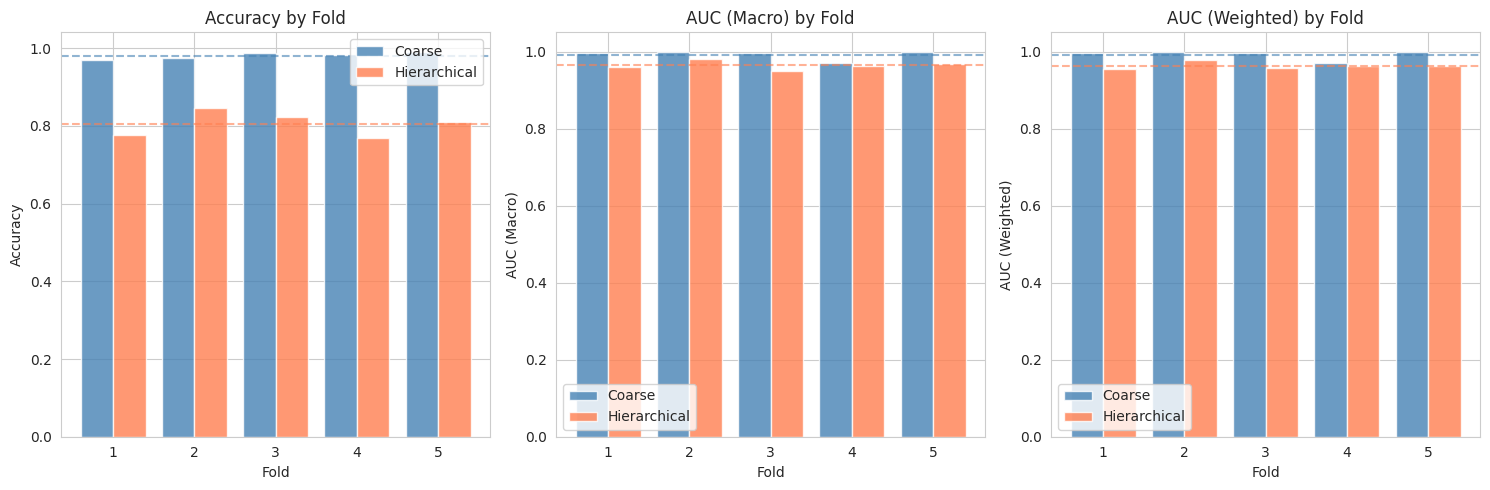


✓ K-fold comparison figure saved to '../figures/kfold_comparison.png'


In [18]:
# Visualize k-fold results
if kfold_path.exists() and coarse_results is not None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    folds = range(1, k_folds + 1)
    
    # Accuracy comparison
    axes[0].bar(np.array(list(folds)) - 0.2, coarse_results['fold_accuracies'], 0.4, label='Coarse', color='steelblue', alpha=0.8)
    axes[0].bar(np.array(list(folds)) + 0.2, hierarchical_results['fold_accuracies'], 0.4, label='Hierarchical', color='coral', alpha=0.8)
    axes[0].axhline(y=np.mean(coarse_results['fold_accuracies']), color='steelblue', linestyle='--', alpha=0.6)
    axes[0].axhline(y=np.mean(hierarchical_results['fold_accuracies']), color='coral', linestyle='--', alpha=0.6)
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy by Fold')
    axes[0].legend()
    axes[0].set_xticks(list(folds))
    
    # AUC Macro comparison
    axes[1].bar(np.array(list(folds)) - 0.2, coarse_results['fold_auc_macro'], 0.4, label='Coarse', color='steelblue', alpha=0.8)
    axes[1].bar(np.array(list(folds)) + 0.2, hierarchical_results['fold_auc_macro'], 0.4, label='Hierarchical', color='coral', alpha=0.8)
    axes[1].axhline(y=np.mean(coarse_results['fold_auc_macro']), color='steelblue', linestyle='--', alpha=0.6)
    axes[1].axhline(y=np.mean(hierarchical_results['fold_auc_macro']), color='coral', linestyle='--', alpha=0.6)
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('AUC (Macro)')
    axes[1].set_title('AUC (Macro) by Fold')
    axes[1].legend()
    axes[1].set_xticks(list(folds))
    
    # AUC Weighted comparison
    axes[2].bar(np.array(list(folds)) - 0.2, coarse_results['fold_auc_weighted'], 0.4, label='Coarse', color='steelblue', alpha=0.8)
    axes[2].bar(np.array(list(folds)) + 0.2, hierarchical_results['fold_auc_weighted'], 0.4, label='Hierarchical', color='coral', alpha=0.8)
    axes[2].axhline(y=np.mean(coarse_results['fold_auc_weighted']), color='steelblue', linestyle='--', alpha=0.6)
    axes[2].axhline(y=np.mean(hierarchical_results['fold_auc_weighted']), color='coral', linestyle='--', alpha=0.6)
    axes[2].set_xlabel('Fold')
    axes[2].set_ylabel('AUC (Weighted)')
    axes[2].set_title('AUC (Weighted) by Fold')
    axes[2].legend()
    axes[2].set_xticks(list(folds))
    
    plt.tight_layout()
    plt.savefig('../figures/kfold_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ K-fold comparison figure saved to '../figures/kfold_comparison.png'")


In [19]:
# Save k-fold summary to CSV for easy reference
if kfold_path.exists() and coarse_results is not None:
    kfold_summary = pd.DataFrame([
        {
            'Model': 'Coarse (Stage 1)',
            'Accuracy Mean': np.mean(coarse_results['fold_accuracies']),
            'Accuracy Std': np.std(coarse_results['fold_accuracies']),
            'AUC Macro Mean': np.mean(coarse_results['fold_auc_macro']),
            'AUC Macro Std': np.std(coarse_results['fold_auc_macro']),
            'AUC Weighted Mean': np.mean(coarse_results['fold_auc_weighted']),
            'AUC Weighted Std': np.std(coarse_results['fold_auc_weighted']),
        },
        {
            'Model': 'Hierarchical (Full)',
            'Accuracy Mean': np.mean(hierarchical_results['fold_accuracies']),
            'Accuracy Std': np.std(hierarchical_results['fold_accuracies']),
            'AUC Macro Mean': np.mean(hierarchical_results['fold_auc_macro']),
            'AUC Macro Std': np.std(hierarchical_results['fold_auc_macro']),
            'AUC Weighted Mean': np.mean(hierarchical_results['fold_auc_weighted']),
            'AUC Weighted Std': np.std(hierarchical_results['fold_auc_weighted']),
        }
    ])
    
    kfold_csv_path = '../results/kfold_summary.csv'
    kfold_summary.to_csv(kfold_csv_path, index=False)
    print(f"\nK-fold summary saved to '{kfold_csv_path}'")
    print("\nK-Fold Summary:")
    print(kfold_summary.to_string(index=False))



K-fold summary saved to '../results/kfold_summary.csv'

K-Fold Summary:
              Model  Accuracy Mean  Accuracy Std  AUC Macro Mean  AUC Macro Std  AUC Weighted Mean  AUC Weighted Std
   Coarse (Stage 1)       0.980582      0.008148        0.992060       0.011319           0.992060          0.011319
Hierarchical (Full)       0.804760      0.028719        0.964349       0.010066           0.962518          0.008273
